#### Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so. 

#### The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it).
#### The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score)

In [2]:
conversion_data = pd.read_csv("/Users/praanshu/Desktop/SFSU/Data Mining/PPTs,data/conversion_data.csv")
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
print(np.count_nonzero(conversion_data.isnull()))     #checking to see if there are any null values in the dataset.
np.unique(conversion_data['total_pages_visited'])

0


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [4]:
# Using the cut function to divide total_pages_visited into different bins: 
# The cuts were found using qcut function to ensure fairly uniform quartiles
# 0-2, 3-4, 5-7, 8 and above 

conversion_data['total_pages_visited_bin'] = pd.cut(x=conversion_data['total_pages_visited'], bins=[0,2,4,7,29])

# Dividing age into different bins: 17-24, 25-30, 31-36, 37 and above.

conversion_data['age_bin'] = pd.cut(x=conversion_data['age'], bins=[16,24,30,36,123] )


#### Since output exists in our dataset and is dichotomous and categorical, we will now perform some exploratory analysis to make sense of the features

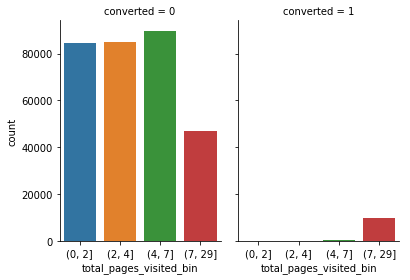

In [5]:
g = sns.catplot(x="total_pages_visited_bin", col="converted",
                data=conversion_data, kind="count",
                height=4, aspect=.7);


#### The plot above shows that people who visted the pages more than 7 times are among the majority converted, followed closely by people who visited pages 4-7 times. This could be either because certain users are more engaged and hence more likely to view more pages before converting. Or this could be due to the fact that checking out inolves landing on more pages.

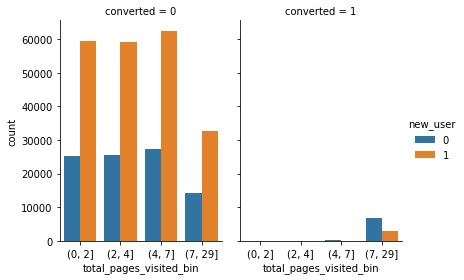

In [6]:
g = sns.catplot(x="total_pages_visited_bin",hue= "new_user",col="converted",
                data=conversion_data, kind="count",
                height=4, aspect=.7);



#### Here we analyze the split of new users vs old with respect to the number of pages visited. We see that of the people converted,  in the total pages visited bin of 7+ , there were more old users than new ones.

In [7]:

conversion_by_country = conversion_data \
    .groupby(['country', 'converted']) \
    .agg({'new_user': 'count'}) \
    .reset_index() \
    .rename({'new_user':'counts'}, axis=1)

df = conversion_by_country \
    .pivot(index='country', columns='converted', values='counts') \
    .reset_index() \
    .rename({0:'not_converted', 1:'converted'}, axis=1)

df.columns.name = None
df['percentage_conversion']= round((df['converted']/(df['converted'] + df['not_converted']))*100,2)
df.sort_values(by='percentage_conversion',inplace= True)
df


,country,not_converted,converted,percentage_conversion
0,China,76500,102,0.13
3,US,171360,6732,3.78
2,UK,45900,2550,5.26
1,Germany,12240,816,6.25


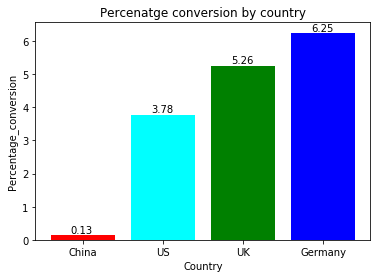

In [8]:

bars= plt.bar(x ='country',height ='percentage_conversion', data=df, color = ['red','cyan','green','blue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.25, yval + .06, yval)

plt.ylabel("Percentage_conversion")
plt.xlabel("Country")
plt.title("Percenatge conversion by country")
plt.show()

#### The above analysis depicts the conversion rate per country. We see that while US has the most absolute number of cases converted, the percentage conversion is highest in Germany and least in China

In [9]:
conversion_by_source = conversion_data \
    .groupby(['source', 'converted']) \
    .agg({'new_user': 'count'}) \
    .reset_index() \
    .rename({'new_user':'counts'}, axis=1)

df_source = conversion_by_source \
    .pivot(index='source', columns='converted', values='counts') \
    .reset_index() \
    .rename({0:'not_converted', 1:'converted'}, axis=1)

df_source.columns.name = None
df_source['percentage_conversion']= round((df_source['converted']/(df_source['converted'] + 
                                                                   df_source['not_converted']))*100,2)
df_source.sort_values(by='percentage_conversion',inplace= True)
df_source

,source,not_converted,converted,percentage_conversion
1,Direct,70380,2040,2.82
2,Seo,149940,5100,3.29
0,Ads,85680,3060,3.45


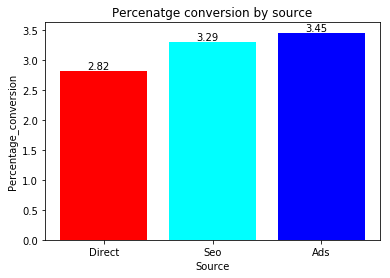

In [10]:
bars= plt.bar(x ='source',height ='percentage_conversion', data=df_source, color = ['red','cyan','blue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+ 0.25, yval+0.03 , yval)

plt.ylabel("Percentage_conversion")
plt.xlabel("Source")
plt.title("Percenatge conversion by source")
plt.show()

#### The above analysis depicts the conversion rate by source. We see that while Seo has most number of absolute conversions, the percentage conversion is highest for Ads, suggesting that Ads is a successful mode of targeting customers

In [189]:
No_of_sessions = len(conversion_data['converted'])
Converted= sum(conversion_data['converted'])
Conversion_rate_actual = Converted/No_of_sessions
print('Overall Conversion rate:', round((Conversion_rate_actual*100),2), '%')

Overall Conversion rate: 3.23 %


#### The overall conversion rate for this dataset is 3.23%

#### We will now conduct statistical analyses on the data set to find the best model for predicting conversion rate

In [11]:
# creating dummy variables

country_dummy = pd.get_dummies(data = conversion_data.country, prefix = 'country', drop_first = True)
source_dummy = pd.get_dummies(data= conversion_data.source, prefix ='source', drop_first= True)

#Since we grouped ages and total pages visited in brackets for better interpretation, we will now
#convert them to dummies

age_dummy = pd.get_dummies(data =conversion_data.age_bin, prefix ='age', drop_first = True)
total_pages_visited_dummy = pd.get_dummies(data =conversion_data.total_pages_visited_bin,\
                                           prefix ='total_page_visited', drop_first = True)

conversion_data = pd.concat([conversion_data, country_dummy, \
                             source_dummy, age_dummy, total_pages_visited_dummy], axis=1)
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted,total_pages_visited_bin,age_bin,country_Germany,country_UK,country_US,source_Direct,source_Seo,"age_(24, 30]","age_(30, 36]","age_(36, 123]","total_page_visited_(2, 4]","total_page_visited_(4, 7]","total_page_visited_(7, 29]"
0,UK,25,1,Ads,1,0,"(0, 2]","(24, 30]",0,1,0,0,0,1,0,0,0,0,0
1,US,23,1,Seo,5,0,"(4, 7]","(16, 24]",0,0,1,0,1,0,0,0,0,1,0
2,US,28,1,Seo,4,0,"(2, 4]","(24, 30]",0,0,1,0,1,1,0,0,1,0,0
3,China,39,1,Seo,5,0,"(4, 7]","(36, 123]",0,0,0,0,1,0,0,1,0,1,0
4,US,30,1,Seo,6,0,"(4, 7]","(24, 30]",0,0,1,0,1,1,0,0,0,1,0


In [12]:
conversion_data['Intercept'] = 1
X = conversion_data[['Intercept','country_Germany','country_UK','country_US','source_Direct',
                    'source_Seo','age_(24, 30]','age_(30, 36]','age_(36, 123]',
                    'total_page_visited_(2, 4]','total_page_visited_(4, 7]','total_page_visited_(7, 29]',
                    'new_user']]
y = conversion_data['converted']


### Logistic regression using statsmodels.api

In [13]:
logit = smf.Logit(y, X)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.071967
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               316200
Model:                          Logit   Df Residuals:                   316187
Method:                           MLE   Df Model:                           12
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.4950
Time:                        20:20:10   Log-Likelihood:                -22756.
converged:                       True   LL-Null:                       -45060.
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -10.7473      0.332    -32.333      0.000     -11.399     -10.096
country_Germany                3.9183      0.110     35.654      0.000       3.703       4.134
country_UK                     3.7239      0.103     36.139      0.000       3.522       3.926
country_US                     3.3616      0.101     33.283      0.000       3.164       3.560
source_Direct                 -0.1975      0.035     -5.703      0.000      -0.265      -0.130
source_Seo                    -0.0494      0.028     -1.759      0.079      -0.105       0.006
age_(24, 30]                  -0.5137      0.029    -17.436      0.000      -0.571      -0.456
age_(30, 36]                  -0.9550      0.034    -28.270      0.000      -1.021      -0.889
age_(36, 123]                 -1.5094      0.040    -37.867      0.000      -1.587      -1.431
total_page_visited_(2, 4]      1.4463      0.351      4.118      0.000       0.758       2.135
total_page_visited_(4, 7]      3.3916      0.321     10.558      0.000       2.762       4.021
total_page_visited_(7, 29]     7.4737      0.317     23.610      0.000       6.853       8.094
new_user                      -1.6954      0.025    -68.084      0.000      -1.744      -1.647
==============================================================================================

Possibly complete quasi-separation: A fraction 0.29 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Upon analysis, I found that the output from statsmodels indicates that the variable total_pages_visited is possibly predicting the output variable perfectly. This indicates quasi-separation but we will not drop this variable from the model otherwise it may introduce bias. 

### Interpretation

Except Source_Seo, all other variables appear to be significant. We can interpret them as:
1. The odds of successfully converting a user in Germany is 391% more than for a user in China. Similarly, the odds of successful conversion for users from UK and US are 370% and 336% more than for users from China respectively.

2. The odds of successfully converting a user via direct marketing is 19% less than targeting them with ads. Similarly, odds of conversion by Seo is 5% less than targeting them with ads

3. The odds of successfully converting a user in age group 24-30 is 51% lower than for users in age group 17-24. Similarly, the odds for users in age group 30-36 and 36 and above are 95% and 150% lower than for users in age group 17-24 respectively. This could be because younger people are more likely to make purchases online.

4. The odds of successfully converting a user who visited the page more than 7 times is 747% more than for a user who visited the page 1-2 times. This suggests that higher the # of times users visit the page, the more likely is their conversion. 

5. The odds of successfully converting a new user is 169% lower than an old user. This could be because old users trust the site and are more willing to make a purchase.


### Using Sklearn and splitting data into train and test set

#### P.S  While logistic regression is best suited for interpretation and not for prediction, we will still run this model to see which variables are important to the model so that we can make informed recommendations to the marketing and product teams

In [141]:
#Here, we are using age and total pages visited as continuous variables

X = conversion_data[['country_Germany','country_UK','country_US','source_Direct',
                    'source_Seo','age','total_pages_visited','new_user']]

y = conversion_data['converted']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



lm = LogisticRegression(solver = 'liblinear', max_iter = 10000)

lm.fit(X_train, y_train)

print("Accuracy with 10 fold CV for liblinear is %f" %cross_val_score(lm, X_train , y_train, cv=10, scoring = 'accuracy').mean())

y_hat_liblinear = lm.predict(X_test)

print("\n",confusion_matrix(y_test, y_hat_liblinear))

Accuracy with 10 fold CV for liblinear is 0.986080

 [[100646    419]
 [  1021   2260]]


In [59]:
precision=2260/(2260+419)
print(precision)

0.843598357596118


In [142]:
#We will now standardize the continuous variables

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

min_max = sc.fit(X_train.loc[:,['age','total_pages_visited']])
X_train_std = min_max.transform(X_train.loc[:,['age','total_pages_visited']])
X_test_std =  min_max.transform(X_test.loc[:,['age','total_pages_visited']])

X_train.loc[:, ['age', 'total_pages_visited']] = X_train_std
X_test.loc[:, ['age', 'total_pages_visited']] = X_test_std


/Users/praanshu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/praanshu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [143]:
X_train.head()

,country_Germany,country_UK,country_US,source_Direct,source_Seo,age,total_pages_visited,new_user
122073,0,0,1,1,0,0.127660,0.250000,0
123957,0,0,1,1,0,0.180851,0.142857,1
152147,0,0,1,1,0,0.255319,0.000000,1
102773,0,0,0,1,0,0.085106,0.250000,1
5562,0,1,0,0,1,0.180851,0.142857,1


### Using 10-fold cross validation to find the best tuning parameter - C using 'liblinear' and l1 penalty

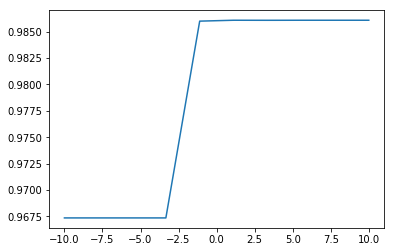

Our optimal C is 12.915497
Our accuracy at optimal C is 0.986089


In [42]:
c_list = np.logspace(-10,10,10) 
c_index = np.linspace(-10,10,10)

cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'liblinear', max_iter  = 10000, penalty = 'l1')
    cv_scores.append(cross_val_score(lm, X_train, y_train, cv = 10, scoring = 'accuracy').mean())

plt.plot(c_index, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))

### Localizing search

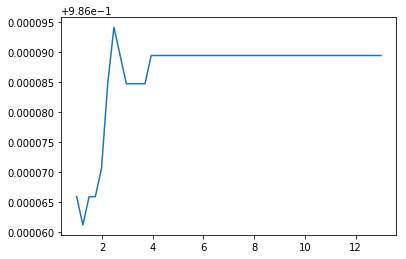

Our optimal C is 2.469388
Our accuracy at optimal C is 0.986094


In [43]:
c_list = np.linspace(1,13,50) 
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'liblinear', max_iter  = 10000, penalty = 'l1', random_state=42)
    cv_scores.append(cross_val_score(lm, X_train, y_train, cv = 10, scoring = 'accuracy').mean())

plt.plot(c_list, cv_scores)
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores)])   
print("Our accuracy at optimal C is %f" %np.max(cv_scores))

In [44]:
lm = LogisticRegression(C = 2.46 ,  solver = 'liblinear', max_iter  = 50000, penalty = 'l1')
lm.fit(X_train,y_train)

Var_coef = zip(lm.coef_[0,:],X_train.columns.values)
print(list(Var_coef))

[(3.6602954794908884, 'country_Germany'), (3.5024916494146026, 'country_UK'), (3.10259818637686, 'country_US'), (-0.18870656126977306, 'source_Direct'), (-0.016439121077746224, 'source_Seo'), (-7.141297815041676, 'age'), (21.35077318709223, 'total_pages_visited'), (-1.7583173774957566, 'new_user')]


In [92]:
# Since no feature has reduced to zero, this suggests that we include all of them in our final model

lr1= LogisticRegression(solver = 'liblinear', max_iter=10000)
lr1.fit(X_train,y_train)

y_hat = lr1.predict(X_test)

No_of_sessions = len(y_test)
Converted= sum(y_hat)
Conversion_rate = Converted/No_of_sessions
print('Predicted Conversion rate:', round((Conversion_rate*100),2),"%")

print ('Actual Conversion rate for test set', round ((sum(y_test)/(No_of_sessions)*100),2),"%")

Predicted Conversion rate: 2.53 %
Actual Conversion rate for test set 3.14 %


In [93]:
prediction = list(map(round, y_hat)) 
confmat= confusion_matrix(y_test,prediction)
TN = confmat[0,0] #True Negative
FN = confmat[1,0] #False Negative
FP = confmat[0,1] #False Positive
TP = confmat[1,1] #True Positive


FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
print("FNR : {0},\nFPR : {1}".format(FNR, FPR))
print(confmat)  

 #This confusion matrix shows that our FNR and FPR both increased as compared to our results from statsmodel.
 #Since our goal is to predict Survival rate with accuracy, we cannot afford to have a high FNR.

FNR : 0.3172813166717464,
FPR : 0.003918270420026715
[[100669    396]
 [  1041   2240]]


In [94]:
precision = 2240/(2240+396)
print(precision)

0.849772382397572


### We see that there is a marginal increase in precision from our base model after we standardized our continuous features. The actual conversion rate of our dataset was 3.23%. We will now explore how changing the threshold changes our prediction rate

In [95]:
def PredictThreshold(Predictprob, Threshold): 
        y_predict = 0
        if (Predictprob >= Threshold):
            y_predict = 1
        return y_predict
    
y_hat_probability = lr1.predict_proba(X_test).T[1]
ThresholdRange =  np.linspace(0, 1, 100)

# Threshold = 0.2
y_hat_predict_threshold= []
for i in range(0,len(y_hat_probability)):
    y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i], .2))
confmat1= (confusion_matrix(y_test, y_hat_predict_threshold))

TN = confmat1[0,0] #True Negative
FN = confmat1[1,0] #False Negative
FP = confmat1[0,1] #False Positive
TP = confmat1[1,1]

FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
Err = float(FP+FN)/(TN+FN+FP+TP)

Precision= float(TP)/(TP+FP)

print("FNR : {}\nFPR : {}\nErr : {}\nPrecision : {}".format(round(FNR,3), round(FPR,3), round(Err,3), round(Precision,3)))

FNR : 0.18
FPR : 0.014
Err : 0.019
Precision : 0.663


In [98]:
# Threshold = 0.3
y_hat_predict_threshold= []
for i in range(0,len(y_hat_probability)):
    y_hat_predict_threshold.append(PredictThreshold(y_hat_probability[i], .3))
confmat1= (confusion_matrix(y_test, y_hat_predict_threshold))

TN = confmat1[0,0] #True Negative
FN = confmat1[1,0] #False Negative
FP = confmat1[0,1] #False Positive
TP = confmat1[1,1]

FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
Err = float(FP+FN)/(TN+FN+FP+TP)
Precision= float(TP)/(TP+FP)

print("FNR : {}\nFPR : {}\nErr : {}\nPrecision : {}".format(round(FNR,3), round(FPR,3), round(Err,3), round(Precision,3)))

FNR : 0.227
FPR : 0.009
Err : 0.016
Precision : 0.744


In [100]:
No_of_sessions = len(y_hat_predict_threshold)
Converted= sum(y_hat_predict_threshold)
Conversion_rate = Converted/No_of_sessions
print('Predicted Conversion rate at threshold 0.3 :', round((Conversion_rate*100),2),"%")

Predicted Conversion rate at threshold 0.3 : 3.27 %


#### Since our precision is high at threshold = 0.3, and the predict conversion rate closely matches the actual rate, we will choose this threshold for our model.

0.9856087318036095


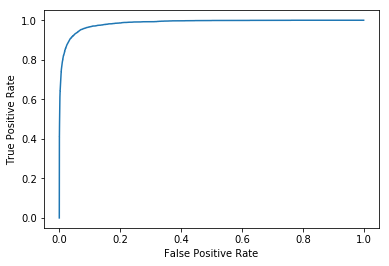

In [72]:
print(roc_auc_score(y_test, y_hat_probability))
vals = roc_curve(y_test, y_hat_probability)

plt.plot(vals[0], vals[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Conclusion: From our logistic regression analysis using sklearn, we found that:

- The prediction of conversion rate for test set is 2.53% while the actual conversion rate for test set was 3.14%. We therefore explored different thresholds to increase precision and settled on 0.3 as it gave a high precision without much increase in error
- The ROC curve is close to 1 indicating a good fit
- The marketing team should focus on the ones our model predicts have a high chance of conversion based on a threshold of 0.3
- If we need to generate more marketing leads, and high precision is not a strong concern, we can consider reducing the threshold

### We will now use KNN, Random Forests and Boosting as these models are better at prediction for classification problems and try to predict conversion rate

## KNN

In [26]:
# #Since our data is already standardised, we will use the same dataset.


In [74]:
from sklearn import neighbors, metrics

knn= neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [75]:
Score = knn.score(X_test, y_test)
print('Score:',Score)
y_pred_knn = knn.predict(X_test)
MissClassificationError = 1 - Score
print(MissClassificationError)


#  We are not sure if there is overfitting as value for KNN was chosen randomly. We will now use CV to chose optimal
# value for Knn.

Score: 0.984675981829682
0.015324018170318032


In [101]:
confmat= confusion_matrix(y_test,y_pred_knn) ## We will comapre this confusion matrix with CM from optimal Knn to see if
                                        ## we could better our model
TN = confmat[0,0] #True Negative
FN = confmat[1,0] #False Negative
FP = confmat[0,1] #False Positive
TP = confmat[1,1] #True Positive


FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
Precision = float(TP)/(TP+FP)
print("FNR : {0},\nFPR : {1},\nPrecision : {2}".format(FNR, FPR, Precision))
print(confmat)   

FNR : 0.3194148125571472,
FPR : 0.0054519368723099,
Precision : 0.8020833333333334
[[100514    551]
 [  1048   2233]]


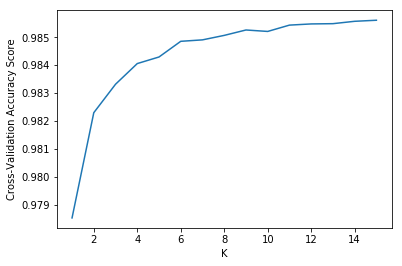

The best K is 15.000000


In [179]:
CV_Scores = []
RangeOfK = range(1,16)

for k in RangeOfK:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights= 'uniform')
    CV_Scores.append(cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy').mean())    

plt.plot(RangeOfK, CV_Scores)
plt.xlabel("K")
plt.ylabel("Cross-Validation Accuracy Score")
plt.show()

print("The best K is %f" %RangeOfK[np.argmax(CV_Scores)])

## Due to the large size of the data, this algorithm is very heavy, and since there is only marginal increase in CV accuracy, and the CV accuracy score is itself very high, we will consider a range of 1-15 for K values. We see highest K is at K=15, but there is only marginal improvement in accuracy beyond k=6

In [ ]:
## We could have chosen k=6 for faster computation without significantly compromising on accuracy.
## But here we use k=15

In [149]:
Knn_15= neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'uniform')

Knn_15.fit(X_train, y_train)

print("Score:", Knn_15.score(X_test,y_test))

Score: 0.9856343319341422


In [180]:
print("Missclassification error :", (1-Score))

Missclassification error : 0.015324018170318032


#####  K=15 produces a high accuracy score of 98.56% with a misclassification error of just 1.5%, showing improvement over our base model of k=5

In [150]:
y_hat = Knn_15.predict(X_test)

confmat= confusion_matrix(y_test,y_hat) 
TN = confmat[0,0] #True Negative
FN = confmat[1,0] #False Negative
FP = confmat[0,1] #False Positive
TP = confmat[1,1] #True Positive

FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
Precision = float(TP)/(TP+FP)
print("FNR : {0},\nFPR : {1},\n Precision: {2}".format(FNR, FPR, Precision))

print(confmat)  

FNR : 0.3236818043279488,
FPR : 0.0043239499332113,
 Precision: 0.8354668674698795
[[100628    437]
 [  1062   2219]]


In [151]:
No_of_sessions = len(y_hat)
Converted= sum(y_hat)
Conversion_rate = Converted/No_of_sessions
print('Predicted Conversion rate:', round((Conversion_rate*100),2),"%")

Predicted Conversion rate: 2.55 %


In [35]:
## Comparing our results with the CM of LR, we see that FNR has increased slightly. 

0.9500688273363233


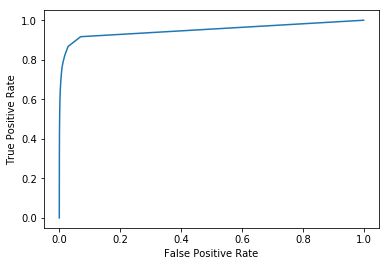

In [161]:
y_hat_probability = Knn_15.predict_proba(X_test).T[1]
print(roc_auc_score(y_test, y_hat_probability))
vals = roc_curve(y_test, y_hat_probability)

plt.plot(vals[0], vals[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### The overall accuracy by ROC curve is less than that for LR but predicted conversion rate is slightly better.

#### Random Forest Classifier

In [123]:
from sklearn.ensemble import RandomForestClassifier


X = conversion_data[['country_Germany','country_UK','country_US','source_Direct',
                    'source_Seo','age','total_pages_visited','new_user']]

y = conversion_data['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


n_estimators= [500,1000,1500,2500]

min_samples_leaf =[5,10]
grid_param= {'n_estimators': n_estimators,
            'min_samples_leaf': min_samples_leaf}

from sklearn.model_selection import RandomizedSearchCV

RFC = RandomForestClassifier(random_state=1)

RFC_random= RandomizedSearchCV(estimator= RFC, param_distributions = grid_param, n_jobs=-1)

RFC_random.fit(X_train,y_train)

print(RFC_random.best_params_)


/Users/praanshu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/praanshu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_estimators': 1500, 'min_samples_leaf': 10}


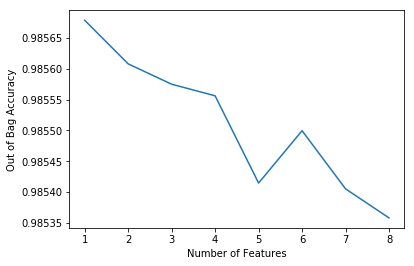

In [124]:
Features = range(1,9)
oob_score_RF = []
for i in Features:
        RFClass = RandomForestClassifier(n_estimators = 1500, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 10, #Minimum number of observations at each terminal node
                           oob_score = True,
                           random_state = 1,
                           n_jobs = -1)
        RFClass.fit(X_train,y_train)  
        oob_score_RF.append(RFClass.oob_score_)

plt.plot(Features, oob_score_RF)
plt.xlabel("Number of Features")
plt.ylabel("Out of Bag Accuracy")
plt.show()             
        

# # it seems like choosing max_features as 1 is our best bet, but can also choose 4 as OOB accuracy is similar

In [130]:
sorted(zip(RFClass.feature_importances_,X_train.columns.values))


[(0.005202288703840498, 'source_Direct'),
 (0.008585865735512425, 'source_Seo'),
 (0.009244473823925346, 'country_Germany'),
 (0.011264761425181792, 'country_UK'),
 (0.012661049285144568, 'country_US'),
 (0.05837553054655556, 'new_user'),
 (0.05886816926604079, 'age'),
 (0.8357978612137984, 'total_pages_visited')]

### We need to be careful while considering the importance of features here as age and total pages visited are both continuous variables and hence may present more weightage than the other dummy variables.

In [132]:
RFClass = RandomForestClassifier(n_estimators = 1500, #Refitting the model with best parameters
                           max_features = 1,     
                           min_samples_leaf = 10, 
                           oob_score = True,
                           random_state = 1,
                           n_jobs = -1)
RFClass.fit(X_train,y_train)  


y_hat = RFClass.predict(X_test)
confmat= confusion_matrix(y_test,y_hat)

TN = confmat[0,0] #True Negative
FN = confmat[1,0] #False Negative
FP = confmat[0,1] #False Positive
TP = confmat[1,1] #True Positive


FNR = float(FN)/(FN + TP)
FPR = float(FP)/(FP + TN)
Precision = float (TP)/(TP+FP)
print("FNR : {0},\nFPR : {1},\nPrecision : {2}".format(FNR, FPR, Precision))
print(confmat)   

FNR : 0.31484303565985977,
FPR : 0.004205214465937763,
Precision : 0.8410026187803965
[[100640    425]
 [  1033   2248]]


In [139]:
No_of_sessions = len(y_hat)
Converted= sum(y_hat)
Conversion_rate = Converted/No_of_sessions
print('Predicted Conversion rate', round((Conversion_rate*100),2),"%")

Predicted Conversion rate 2.56 %


### The predicted conversion rate for Random Forests is slightly better than that from LR and KNN, but our precision decreased slightly from LR using sklearn

### Boosting

In [127]:
parameter_list = {'learning_rate':[0.05, 0.25, 0.75], 'n_estimators':[1000,1500,2000],
                 'max_depth':[2,3]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(min_samples_split=2,
                                                            min_samples_leaf=10, subsample=1,
                                                            max_features='sqrt', random_state=1), 
                                                            param_grid = parameter_list, scoring='accuracy',
                                                            n_jobs=-1,iid=False, cv=5)


tuning.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_sa...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.25, 0.75], 'n_estimators': [1000, 1500, 2000], 'max_depth': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [128]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 2000},
 0.9860375524477865)

Accuracy of the GBM on test set: 0.986
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101065
           1       0.84      0.69      0.76      3281

   micro avg       0.99      0.99      0.99    104346
   macro avg       0.92      0.84      0.88    104346
weighted avg       0.99      0.99      0.99    104346



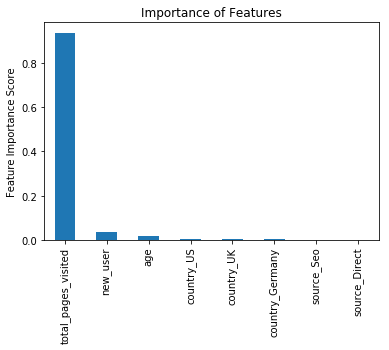

In [129]:
final_model=GradientBoostingClassifier(learning_rate = 0.05, n_estimators=2000 ,max_depth=2, 
                               min_samples_split=20, min_samples_leaf=7,max_features='sqrt' , 
                               subsample=0.95, random_state=1)

final_model.fit(X_train,y_train)

predictors=list(X_train)
imp_features = pd.Series(final_model.feature_importances_, predictors).sort_values(ascending=False)
imp_features.plot(kind='bar', title='Importance of Features')


plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(final_model.score(X_test, y_test)))
pred=final_model.predict(X_test)

print(classification_report(y_test, pred))

In [140]:
No_of_sessions = len(pred)
Converted= sum(pred)
Conversion_rate = Converted/No_of_sessions
print('Predicted Conversion rate', round((Conversion_rate*100),2),"%")

Predicted Conversion rate 2.58 %


### The predicted conversion rate for boosting is the best of the lot, with precision being almost the same as in the other models. 


## Summary and conclusion

In this analysis I explored several models to predict the conversion rate for users. At first, I performed exploratory analyses of the features to make sense of the data. My key findings from the exploratory analysis were: 

1. Old users who visited the page 7 or more times were among the highest ones converted
2. Germany had the highest percentage conversion rate among countries
3. Ads were the most successful source of targeting customers
4. The overall conversion rate in the dataset was 3.2% only



Since this was a classification problem with dichotomous output, I decided to use logistic regression, KNN, Random Forests and Boosting methods to predict the converison rate. While logistic regression is more suited for interpretation, my goal in using both- sklearn and statsmodels was to interpret the coefficients and see how well the model performs compared to the others. I also refrained from using Decision Trees since it is more suited for interpretation.

#### LR using Statsmodels: 
I then tried to run a logistic regression using statsmodels.api in order to interpret the features in the model. To do that, I grouped together ages and total pages visited so that our interpretation for those features is easier. Upon running the model, it was clear that total_pages_visited is predicting the output almost completely, resulting in a possible complete quasi seperation. Nevertheless, I did not remove the feature from the model, else it would introduce a bias. Source_Seo was insignificant but was not removed from the model as its other dummies were significant.

#### LR using Sklearn:
In order to find which variables should be kept in the model, I used Sklearn, and tried to find the best tuning parameter C. Interestingly, none of the features reduced to zero, suggesting all are significant. However, after standardizing the features in order to tune C, the precision rate improved slightly to 0.89 and prediction of conversion rate was 2.53%. That suggested, that if we were to reach out to the marketing team with the leads generated from this model, there is a high chance of conversion of previously non-converts. Here, we can take the False Positives as leads as the model suggests they had a higher likelihood to convert, but they did not in the previous session.

I then tried to play around with the threshold values. At a threshold of 0.3, the precision rate dropped slightly but the prediction rate improved. This meant that we can now reach out to the marketing team with an even larger set of lead generation, however, they probably will be slightly less reliable was the previous ones.

#### KNN:
Next, I used KNN model for prediction of converison rate. The algorithm was pretty computation heavy, and so I tried to limit the range of K as the accuracy for almost all values in range(1,16) was above 98%. The prediction for conversion rate showed improvement over the rate we got from logistic regression at 2.55%

#### Random Forests:
Using Random forests, I first tried to tune the hyper parameters using Randomized Search CV and found optimal value for n_estimators, min_samples_leaf and max_features. Using those optimal values, I refit the RF model and found the predicted conversion rate to be 2.56%. It was marginally better than that for KNN. I also found the most important features, but there is a possibility of bias there as age and total_pages_visited were continuous variables and may have had more importance than the dummies. So we cannot trust that completely.

#### Boosting:
Finally, I tried using Boosting to predict the conversion rate, and tuning the hyperparameters with Grid search on train set. Using those tuned hyper parameters to fit the model, I found that the precision for prediction of conversion rate is 0.84 and the predicted conversion rate was 2.58%. This was better than what we found for all other models and gave the best prediction of the lot.





## Recommendation to marketing and product team

In order to improve the conversion rate, my recommendation would be:

1. Since our Boosting model has the highest predicted conversion rate, they should target the leads (False Positives) generated from that model for a higher probability of conversion.

2. The marketing team should also explore the leads generated from logistic regression model at a threshold of 0.3 if they need a larger pool to pursue

3. Our exploratory analyses, Random forests and Boosting also suggested that old customers, who have visited the page more than 7 times are more likely to convert than anyone else. The marketing team should hence target those customers as well, as they have high probability of conversion

4. Another suggestion for the product team could be to think of ways to make their product and website more appealing to new customers in the higher age bracket, as elder customers tend to be more vary of online purchases 

5. While the models did not deem source of marketing as an important feature, our exploratory analysis did suggest that there were more successful conversions when the source was Ads as compared to direct marketing. Hence, it may be beneficial to focus more on marketing via Ads. If however Ads are more expensive, we can resort to other marketing channels without much hit to conversions. More cost-benefit analysis can be undertaken to understand and optimize marketing channel spend.
